In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.convnet import do_train_trials, train_net, evaluate_net_classes, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

# Training for the boolean target

In [4]:
#import data for a 1000 pairs
N = 1000
dataset = DlDataset(N, normalize=True, upsample=None)
datasetShape = list(dataset.__shape__()[1:])

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 linear layers, no batch norm
2. 2 conv layers, 2 batch norm layers, 2 linear layers
3. 3 conv layers, 2 linear layers, no batch norm
4. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer

In [5]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_bnorm'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34442
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_bnorm'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16

In [6]:
# Train parameter
epochs = 15
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3
batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 
criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader£
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset.train()
    elif mode == 'test':
        dataset.test()
    dataloader.append(dataset.return_dataloader(**batch_spec))


** A single training run using the 'train_net' function: **

In [7]:
# Train each model with the same parameters
perf_summary = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.40s, Train Loss: nan, Train Acc: 0.46, Val Loss: nan, Val Acc: 0.47
Epoch 1: Duration: 0.36s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 2: Duration: 0.41s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 3: Duration: 0.39s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 4: Duration: 0.37s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 5: Duration: 0.41s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 6: Duration: 0.39s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 7: Duration: 0.42s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
Epoch 8: Duration: 0.37s, Train Loss: nan, Train Acc: 0.47, 

Model: 2conv_2lin           max Test Acc: 0.474
Model: 2conv_2lin_bnorm     max Test Acc: 0.999
Model: 3conv_2lin           max Test Acc: 0.708
Model: 2conv_2lin_2bn_1do   max Test Acc: 0.938


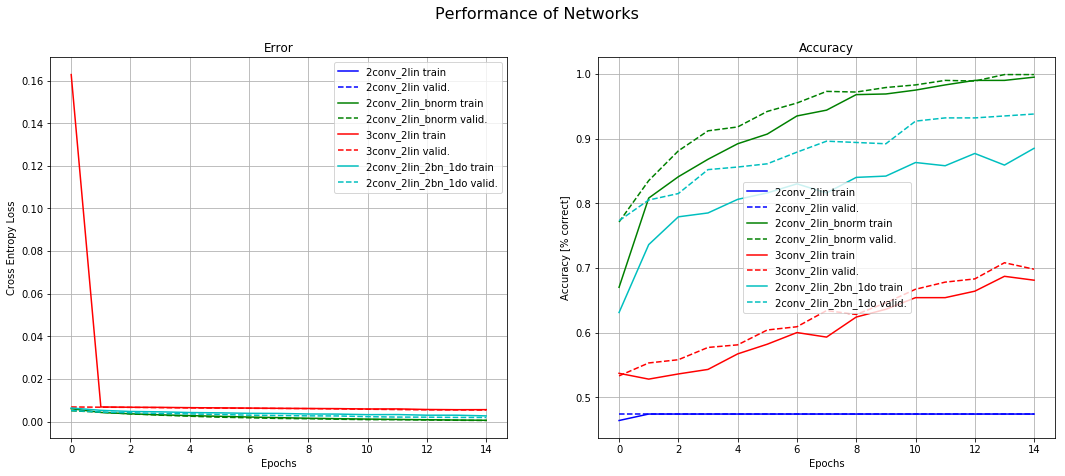

In [8]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model
    avg_loss_train = mod_perf.get_performance('train_loss')
    avg_loss_test = mod_perf.get_performance('test_loss')
    ax1.set_title('Error')
    ax1.plot(range(0,epochs), avg_loss_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.plot(range(0,epochs), avg_loss_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model
    avg_acc_train = mod_perf.get_performance('train_accuracy')
    avg_acc_test = mod_perf.get_performance('test_accuracy')
    ax2.set_title('Accuracy')
    ax2.plot(range(0,epochs), avg_acc_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.plot(range(0,epochs), avg_acc_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
    print('Model: {:<20} max Test Acc: {:>5.3f}'.format(model_name, max(avg_acc_test)))
ax2.grid()
ax2.legend();


Predicted Target: 1, Real Target: 1
Real classes are, left: 0 right: 0
Predicted Target: 0, Real Target: 0
Real classes are, left: 7 right: 6


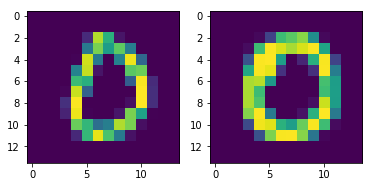

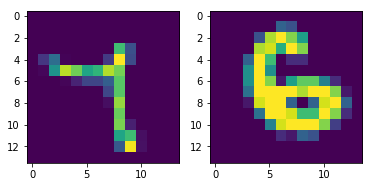

In [9]:
dataset.test()
dataset.infere(models[3],5);
dataset.infere(models[3],6);

** Multiple training trials using the 'do_train_trials' function: **

In [10]:
trial_summaries = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(5, model, device, optim_spec, criterion, dataset, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.45s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 1: Duration: 0.44s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 2: Duration: 0.47s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 3: Duration: 0.44s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 4: Duration: 0.42s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 5: Duration: 0.39s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 6: Duration: 

----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.41s, Train Loss: 6.09e-03, Train Acc: 0.68, Val Loss: 5.00e-03, Val Acc: 0.78
Epoch 1: Duration: 0.38s, Train Loss: 4.41e-03, Train Acc: 0.80, Val Loss: 4.43e-03, Val Acc: 0.79
Epoch 2: Duration: 0.38s, Train Loss: 3.51e-03, Train Acc: 0.85, Val Loss: 3.21e-03, Val Acc: 0.88
Epoch 3: Duration: 0.37s, Train Loss: 2.97e-03, Train Acc: 0.89, Val Loss: 2.52e-03, Val Acc: 0.92
Epoch 4: Duration: 0.38s, Train Loss: 2.59e-03, Train Acc: 0.90, Val Loss: 2.25e-03, Val Acc: 0.94
Epoch 5: Duration: 0.38s, Train Loss: 2.19e-03, Train Acc: 0.93, Val Loss: 1.84e-03, Val Acc: 0.96
Epoch 6: Duration: 0.42s, Train Loss: 1.88e-03, Train Acc: 0.94, Val Loss: 2.14e-03, Val Acc: 0.91
Epoch 7: Duration: 0.47s, Train Loss: 1.74e-03, Train Acc: 0.95, Val Loss: 1.37e-03, Val

Epoch 12: Duration: 0.55s, Train Loss: 8.66e-04, Train Acc: 0.99, Val Loss: 7.54e-04, Val Acc: 1.00
Epoch 13: Duration: 0.46s, Train Loss: 7.34e-04, Train Acc: 0.99, Val Loss: 5.76e-04, Val Acc: 1.00
Epoch 14: Duration: 0.47s, Train Loss: 6.11e-04, Train Acc: 1.00, Val Loss: 5.02e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Running model: 3conv_2lin
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.38s, Train Loss: nan, Train Acc: 0.48, Val Loss: nan, Val Acc: 0.44
Epoch 1: Duration: 0.38s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, Val Acc: 0.44
Epoch 2: Duration: 0.37s, Train Loss: nan, Train Acc: 0.44, Val Loss: nan, 

Epoch 14: Duration: 0.39s, Train Loss: nan, Train Acc: 0.47, Val Loss: nan, Val Acc: 0.47
----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn_1do
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.50s, Train Loss: 6.25e-03, Train Acc: 0.64, Val Loss: 5.54e-03, Val Acc: 0.73
Epoch 1: Duration: 0.47s, Train Loss: 5.33e-03, Train Acc: 0.73, Val Loss: 4.59e-03, Val Acc: 0.82
Epoch 2: Duration: 0.49s, Train Loss: 4.99e-03, Train Acc: 0.74, Val Loss: 4.12e-03, Val Acc: 0.83
Epoch 3: Duration: 0.48s, Train Loss: 4.49e-03, Train Acc: 0.80, Val Loss: 3.62e-03, Val Acc: 0.86
Epoch 4: Duration: 0.47s, Train Loss: 4.63e-03, Train Acc: 

Epoch 9: Duration: 0.46s, Train Loss: 3.49e-03, Train Acc: 0.85, Val Loss: 2.53e-03, Val Acc: 0.91
Epoch 10: Duration: 0.47s, Train Loss: 3.46e-03, Train Acc: 0.85, Val Loss: 2.35e-03, Val Acc: 0.92
Epoch 11: Duration: 0.66s, Train Loss: 3.33e-03, Train Acc: 0.85, Val Loss: 2.32e-03, Val Acc: 0.92
Epoch 12: Duration: 1.22s, Train Loss: 3.33e-03, Train Acc: 0.85, Val Loss: 2.14e-03, Val Acc: 0.92
Epoch 13: Duration: 0.76s, Train Loss: 2.95e-03, Train Acc: 0.87, Val Loss: 1.96e-03, Val Acc: 0.94
Epoch 14: Duration: 0.48s, Train Loss: 2.86e-03, Train Acc: 0.87, Val Loss: 1.73e-03, Val Acc: 0.95


In [11]:
#trial_summaries = perf_summary[4:]

In [12]:
trial_summaries[1].get_performance('std_train_loss')

tensor([0.0002, 0.0002, 0.0003, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0004,
        0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002])

Model: 2conv_2lin           max Test Acc: 0.457
Model: 2conv_2lin_bnorm     max Test Acc: 0.997
Model: 3conv_2lin           max Test Acc: 0.453
Model: 2conv_2lin_2bn_1do   max Test Acc: 0.953


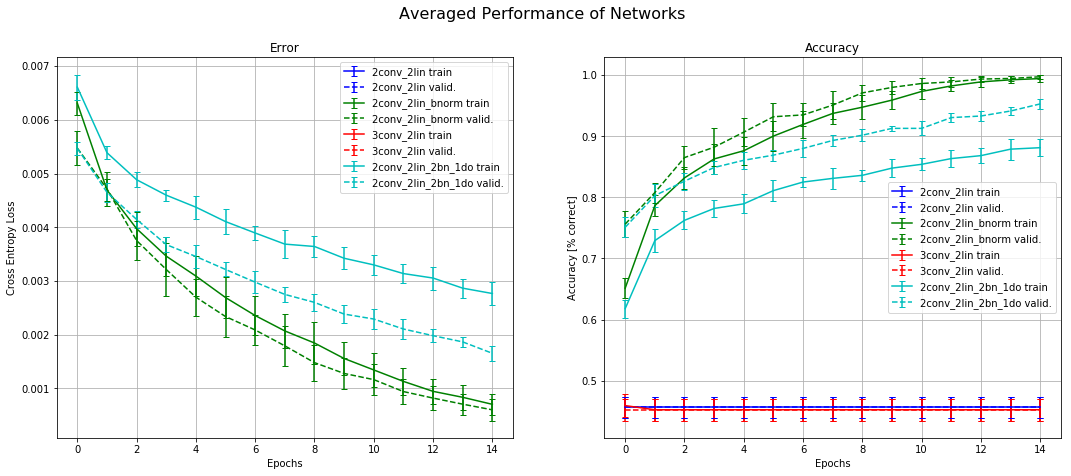

In [13]:
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Averaged Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(trial_summaries):
    model_name = mod_perf.model
    avg_loss_train = mod_perf.get_performance('avg_train_loss')
    avg_loss_test = mod_perf.get_performance('avg_test_loss')
    std_loss_train = mod_perf.get_performance('std_train_loss')
    std_loss_test = mod_perf.get_performance('std_test_loss')
    ax1.set_title('Error') 
    ax1.errorbar(range(0,epochs), avg_loss_train.numpy(), std_loss_train.numpy(), capsize=3, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.errorbar(range(0,epochs), avg_loss_test.numpy(), std_loss_test.numpy(), capsize=3, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(trial_summaries):
    model_name = mod_perf.model
    avg_acc_train = mod_perf.get_performance('avg_train_accuracy')
    avg_acc_test = mod_perf.get_performance('avg_test_accuracy')
    std_acc_train = mod_perf.get_performance('std_train_accuracy')
    std_acc_test = mod_perf.get_performance('std_test_accuracy')
    ax2.set_title('Accuracy')
    ax2.errorbar(range(0,epochs), avg_acc_train.numpy(), std_acc_train.numpy(), capsize=3, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.errorbar(range(0,epochs), avg_acc_test.numpy(), std_acc_test.numpy(), capsize=3, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
    print('Model: {:<20} max Test Acc: {:>5.3f}'.format(model_name, max(avg_acc_test)))
ax2.grid()
ax2.legend();

# Training for the digit classes

In [85]:
# Train for classes and not the target.

dataset_classes = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

#dataset_test_classes = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

#dataset_train_classes.train()
#dataset_test_classes.test()


datasetShape_classes = list(dataset_classes.__shape__()[1:])

In [86]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models_digit = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_classes, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_classes, config_2c_2l_2bn, name='2conv_2lin_2bn'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_classes, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_classes, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models_digit:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  10                  330
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34506
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16


In [87]:
# Train parameter
epochs = 15
mini_batch_size = 100
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}
device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

criterion = torch.nn.CrossEntropyLoss()
# Prepare dataloader£
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset_classes.train()
    elif mode == 'test':
        dataset_classes.test()
    dataloader.append(dataset_classes.return_dataloader(**batch_spec))


** A single training run using the 'train_net' function: **

In [40]:
# Train each model with the same parameters
perf_summary = []
for model in models_digit:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.33s, Train Loss: 1.68e+01, Train Acc: 0.14, Val Loss: 2.23e-02, Val Acc: 0.14
Epoch 1: Duration: 0.36s, Train Loss: 2.24e-02, Train Acc: 0.14, Val Loss: 2.22e-02, Val Acc: 0.14
Epoch 2: Duration: 0.36s, Train Loss: 2.22e-02, Train Acc: 0.14, Val Loss: 2.20e-02, Val Acc: 0.15
Epoch 3: Duration: 0.41s, Train Loss: 2.20e-02, Train Acc: 0.15, Val Loss: 2.19e-02, Val Acc: 0.15
Epoch 4: Duration: 0.41s, Train Loss: 2.19e-02, Train Acc: 0.15, Val Loss: 2.19e-02, Val Acc: 0.15
Epoch 5: Duration: 0.37s, Train Loss: 2.19e-02, Train Acc: 0.15, Val Loss: 2.19e-02, Val Acc: 0.15
Epoch 6: Duration: 0.36s, Train Loss: 2.19e-02, Train Acc: 0.15, Val Loss: 2.19e-02, Val Acc: 0.15
Epoch 7: Duration: 0.36s, Train Loss: 2.19e-02, Train Acc: 0.15, Val Loss: 2.19

Model: 2conv_2lin           max Test Acc: 0.154
Model: 2conv_2lin_2bn       max Test Acc: 0.998
Model: 3conv_2lin           max Test Acc: 0.093
Model: 2conv_2lin_2bn_1do   max Test Acc: 0.977


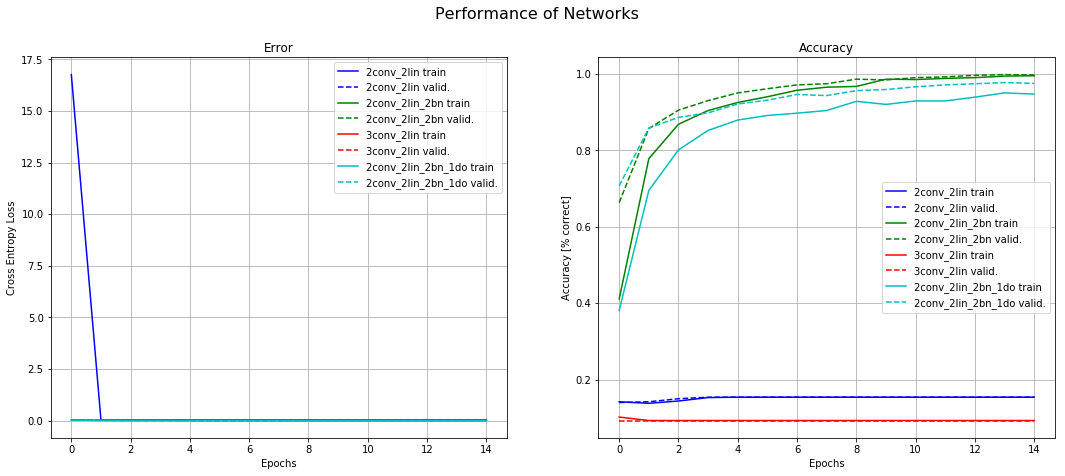

In [41]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model
    avg_loss_train = mod_perf.get_performance('train_loss')
    avg_loss_test = mod_perf.get_performance('test_loss')
    ax1.set_title('Error')
    ax1.plot(range(0,epochs), avg_loss_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.plot(range(0,epochs), avg_loss_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model
    avg_acc_train = mod_perf.get_performance('train_accuracy')
    avg_acc_test = mod_perf.get_performance('test_accuracy')
    ax2.set_title('Accuracy')
    ax2.plot(range(0,epochs), avg_acc_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.plot(range(0,epochs), avg_acc_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
    print('Model: {:<20} max Test Acc: {:>5.3f}'.format(model_name, max(avg_acc_test)))
ax2.grid()
ax2.legend();

### Evaluating target boolean

In [43]:
target_accuracy = []
for model in models_digit:
    target_accuracy.append(evaluate_net_classes(model,dataset_classes))
    print('Model: {:<20} Target Acc: {:>5.3f}'.format(model.name(), target_accuracy[-1]))


Model: 2conv_2lin           Target Acc: 0.572
Model: 2conv_2lin_2bn       Target Acc: 0.974
Model: 3conv_2lin           Target Acc: 0.551
Model: 2conv_2lin_2bn_1do   Target Acc: 0.972


Predicted Class: 0, Real Class: 0
Predicted Class: 9, Real Class: 9
Real Target is: 1
Predicted Target is: 1


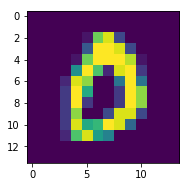

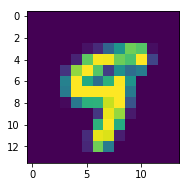

In [44]:
dataset_classes.test()
dataset_classes.selectSplittedDataset('left')
pred_1, classes_1, target_1 = dataset_classes.infere(models_digit[3],10);

dataset_classes.selectSplittedDataset('right')
pred_2, classes_2, target_2 = dataset_classes.infere(models_digit[3],10);
print("Real Target is: {}".format(target_1))
print("Predicted Target is: {}".format((pred_1 <= pred_2).item()))

** Multiple training trials using the 'do_train_trials' function: **

In [91]:
trial_summaries_digit = []
for model in models_digit:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(5, model, device, optim_spec, criterion, dataset_classes, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries_digit.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
0.535
0.535
Epoch 0: Duration: 0.42s, Train Loss: 4.63e+13, Train Acc: 0.11, Val Loss: 2.31e-02, Val Acc: 0.10
0.535
0.535
Epoch 1: Duration: 0.41s, Train Loss: 2.31e-02, Train Acc: 0.10, Val Loss: 2.31e-02, Val Acc: 0.10
0.535
0.535
Epoch 2: Duration: 0.41s, Train Loss: 2.31e-02, Train Acc: 0.10, Val Loss: 2.31e-02, Val Acc: 0.10
0.535
0.535
Epoch 3: Duration: 0.40s, Train Loss: 2.31e-02, Train Acc: 0.10, Val Loss: 6.67e+27, Val Acc: 0.10
0.535
0.535
Epoch 4: Duration: 0.41s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.09
0.535
0.

0.526
0.526
Epoch 8: Duration: 0.43s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 9: Duration: 0.45s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 10: Duration: 0.43s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 11: Duration: 0.43s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 12: Duration: 0.44s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 13: Duration: 0.44s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
0.526
0.526
Epoch 14: Duration: 0.41s, Train Loss: nan, Train Acc: 0.11, Val Loss: nan, Val Acc: 0.11
----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
--------------------------------------------------------

0.972
0.972
Epoch 13: Duration: 0.49s, Train Loss: 7.67e-04, Train Acc: 0.99, Val Loss: 6.17e-04, Val Acc: 1.00
0.972
0.971
Epoch 14: Duration: 0.49s, Train Loss: 6.45e-04, Train Acc: 0.99, Val Loss: 5.58e-04, Val Acc: 1.00
----------------------------------------------------------------------------------------------------
Running Trial: 4
----------------------------------------------------------------------------------------------------
0.8
0.785
Epoch 0: Duration: 0.55s, Train Loss: 1.88e-02, Train Acc: 0.39, Val Loss: 1.39e-02, Val Acc: 0.61
0.894
0.894
Epoch 1: Duration: 0.54s, Train Loss: 1.00e-02, Train Acc: 0.72, Val Loss: 7.59e-03, Val Acc: 0.84
0.931
0.925
Epoch 2: Duration: 0.49s, Train Loss: 6.15e-03, Train Acc: 0.86, Val Loss: 4.60e-03, Val Acc: 0.90
0.94
0.939
Epoch 3: Duration: 0.46s, Train Loss: 4.22e-03, Train Acc: 0.90, Val Loss: 3.36e-03, Val Acc: 0.93
0.95
0.949
Epoch 4: Duration: 0.46s, Train Loss: 3.11e-03, Train Acc: 0.93, Val Loss: 2.48e-03, Val Acc: 0.95
0.959


0.567
0.567
Epoch 3: Duration: 0.45s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 4: Duration: 0.46s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 5: Duration: 0.49s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 6: Duration: 0.47s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 7: Duration: 0.60s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 8: Duration: 0.50s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 9: Duration: 0.48s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 10: Duration: 0.49s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 11: Duration: 0.56s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, Val Acc: 0.09
0.567
0.567
Epoch 12: Duration: 0.53s, Train Loss: nan, Train Acc: 0.09, Val Loss: nan, V

0.949
0.962
Epoch 10: Duration: 0.59s, Train Loss: 2.53e-03, Train Acc: 0.93, Val Loss: 1.54e-03, Val Acc: 0.96
0.953
0.97
Epoch 11: Duration: 0.60s, Train Loss: 2.49e-03, Train Acc: 0.93, Val Loss: 1.43e-03, Val Acc: 0.96
0.943
0.974
Epoch 12: Duration: 0.58s, Train Loss: 2.40e-03, Train Acc: 0.94, Val Loss: 1.28e-03, Val Acc: 0.97
0.956
0.972
Epoch 13: Duration: 0.60s, Train Loss: 2.19e-03, Train Acc: 0.94, Val Loss: 1.14e-03, Val Acc: 0.97
0.95
0.972
Epoch 14: Duration: 0.61s, Train Loss: 2.17e-03, Train Acc: 0.94, Val Loss: 1.03e-03, Val Acc: 0.97
----------------------------------------------------------------------------------------------------
Running Trial: 3
----------------------------------------------------------------------------------------------------
0.787
0.842
Epoch 0: Duration: 0.58s, Train Loss: 1.80e-02, Train Acc: 0.40, Val Loss: 1.38e-02, Val Acc: 0.74
0.858
0.903
Epoch 1: Duration: 0.59s, Train Loss: 1.02e-02, Train Acc: 0.74, Val Loss: 7.12e-03, Val Acc: 0.86
0

In [92]:
trial_summaries_digit[3].get_performance('std_test_target_accuracy')

tensor([0.0191, 0.0156, 0.0081, 0.0102, 0.0095, 0.0064, 0.0054, 0.0055, 0.0059,
        0.0036, 0.0060, 0.0051, 0.0079, 0.0068, 0.0049])

Model: 2conv_2lin           max Test Acc: 0.530
Model: 2conv_2lin_2bn       max Test Acc: 0.967
Model: 3conv_2lin           max Test Acc: 0.632
Model: 2conv_2lin_2bn_1do   max Test Acc: 0.968


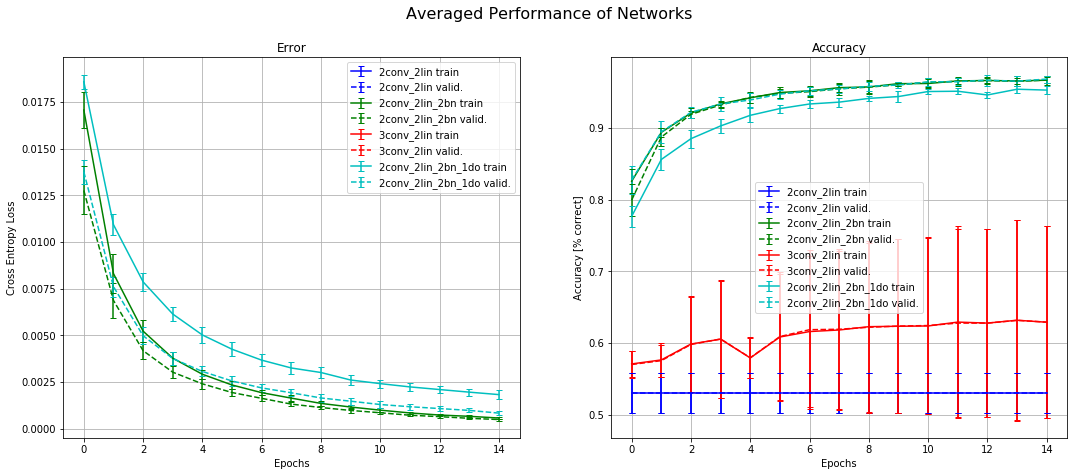

In [93]:
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Averaged Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(trial_summaries_digit):
    model_name = mod_perf.model
    avg_loss_train = mod_perf.get_performance('avg_train_loss')
    avg_loss_test = mod_perf.get_performance('avg_test_loss')
    std_loss_train = mod_perf.get_performance('std_train_loss')
    std_loss_test = mod_perf.get_performance('std_test_loss')
    ax1.set_title('Error') 
    ax1.errorbar(range(0,epochs), avg_loss_train.numpy(), std_loss_train.numpy(), capsize=3, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.errorbar(range(0,epochs), avg_loss_test.numpy(), std_loss_test.numpy(), capsize=3, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(trial_summaries_digit):
    model_name = mod_perf.model
    avg_acc_train = mod_perf.get_performance('avg_train_target_accuracy')
    avg_acc_test = mod_perf.get_performance('avg_test_target_accuracy')
    std_acc_train = mod_perf.get_performance('std_train_target_accuracy')
    std_acc_test = mod_perf.get_performance('std_test_target_accuracy')
    ax2.set_title('Accuracy')
    ax2.errorbar(range(0,epochs), avg_acc_train.numpy(), std_acc_train.numpy(), capsize=3, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.errorbar(range(0,epochs), avg_acc_test.numpy(), std_acc_test.numpy(), capsize=3, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
    print('Model: {:<20} max Test Acc: {:>5.3f}'.format(model_name, max(avg_acc_test)))
ax2.grid()
ax2.legend();